In [1]:
import numpy as np
import nibabel as nib

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import activations
import tensorflow.keras.backend as K

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)
rnd_g = np.random.default_rng(SEED)  # Random Generator

2025-11-12 15:48:19.817797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762962499.841393   18055 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762962499.848545   18055 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
import matplotlib.pylab as plt

%matplotlib inline

## Les données

### Observation

In [3]:
DATA = "/kaggle/input/iseg-2017/iSeg-2017-Training/"
DATA_TEST = "/kaggle/input/iseg-2017/iSeg-2017-Testing/"
!ls $DATA

subject-10-label.hdr  subject-3-T1.hdr	   subject-6-T2.hdr
subject-10-label.img  subject-3-T1.img	   subject-6-T2.img
subject-10-T1.hdr     subject-3-T2.hdr	   subject-7-label.hdr
subject-10-T1.img     subject-3-T2.img	   subject-7-label.img
subject-10-T2.hdr     subject-4-label.hdr  subject-7-T1.hdr
subject-10-T2.img     subject-4-label.img  subject-7-T1.img
subject-1-label.hdr   subject-4-T1.hdr	   subject-7-T2.hdr
subject-1-label.img   subject-4-T1.img	   subject-7-T2.img
subject-1-T1.hdr      subject-4-T2.hdr	   subject-8-label.hdr
subject-1-T1.img      subject-4-T2.img	   subject-8-label.img
subject-1-T2.hdr      subject-5-label.hdr  subject-8-T1.hdr
subject-1-T2.img      subject-5-label.img  subject-8-T1.img
subject-2-label.hdr   subject-5-T1.hdr	   subject-8-T2.hdr
subject-2-label.img   subject-5-T1.img	   subject-8-T2.img
subject-2-T1.hdr      subject-5-T2.hdr	   subject-9-label.hdr
subject-2-T1.img      subject-5-T2.img	   subject-9-label.img
subject-2-T2.hdr      subject-6-la

Regardons le 10e patient.

In [4]:
# https://nipy.org/nibabel/gettingstarted.html

gt = nib.load(DATA+"subject-10-label.hdr").get_fdata()
t1 = nib.load(DATA+"subject-10-T1.hdr").get_fdata()
t2 = nib.load(DATA+"subject-10-T2.hdr").get_fdata()

In [5]:
t1.shape, t1.dtype

((144, 192, 256, 1), dtype('float64'))

In [6]:
def plot_slice(indice, axis):
    fig, ax = plt.subplots(1, 3, figsize=(16,10))
    ax[0].imshow(t1.take(indices=indice, axis=axis))
    ax[0].set_title("T1")
    ax[1].imshow(t2.take(indices=indice, axis=axis))
    ax[1].set_title("T2")
    ax[2].imshow(gt.take(indices=indice, axis=axis))
    ax[2].set_title("Vérité terrain")

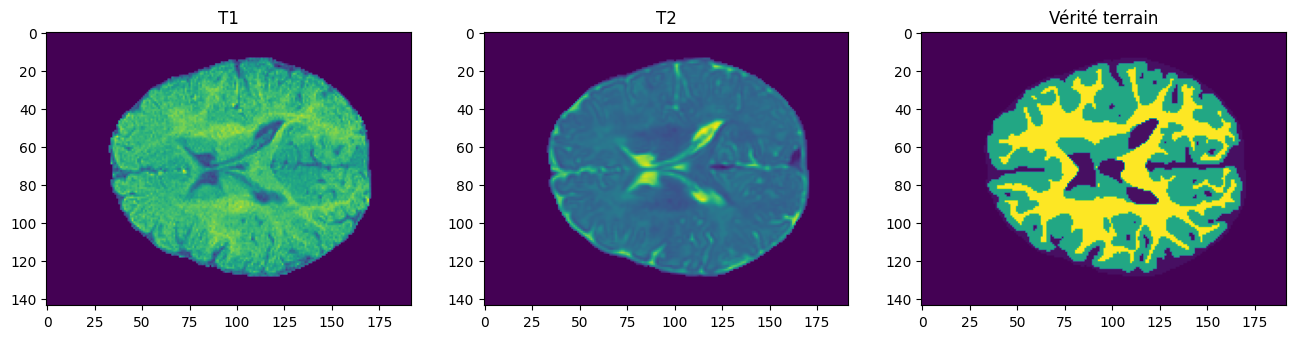

In [7]:
plot_slice(153,2)

In [8]:
labels = np.unique(gt)
labels

array([  0.,  10., 150., 250.])

Autre coupe

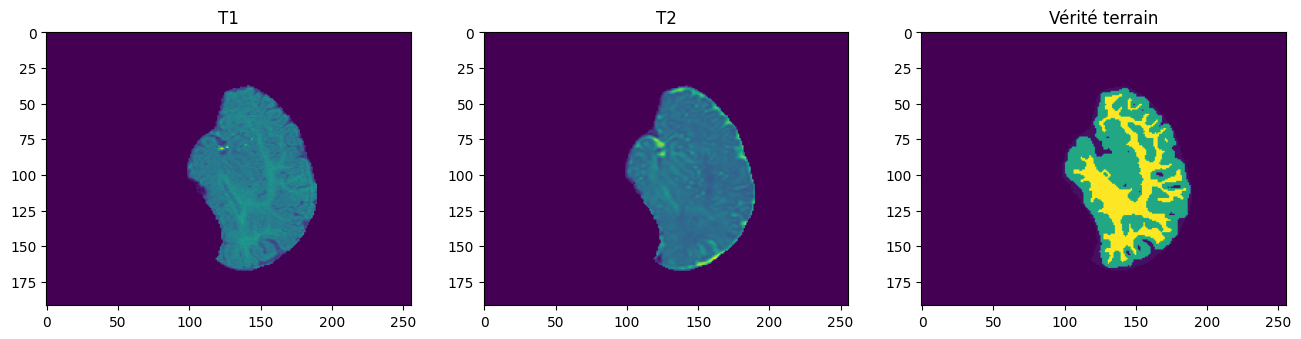

In [9]:
plot_slice(100,0)

### Préparation des données

Donc en fait on a un paquet de données énorme si on compte en images 2D. On va tout stocker en mémoire et ensuite on choisira aléatoirement. Comme c'est lourd, il y a aussi une version avec un générateur qui ne
stocke que les images 3D et génère les images 2D à la volée.


In [10]:
gt = np.array([nib.load(f"{DATA}/subject-{x}-label.img").get_fdata() for x in range(1,11)], dtype='float32')
t1 = np.array([nib.load(f"{DATA}/subject-{x}-T1.img").get_fdata() for x in range(1,11)], dtype='float32')
t2 = np.array([nib.load(f"{DATA}/subject-{x}-T2.img").get_fdata() for x in range(1,11)], dtype='float32')

La vérité terrain est découpée en 4 couches, 1 par étiquette :

In [11]:
gt = np.array(gt == labels)
gt.shape

(10, 144, 192, 256, 4)

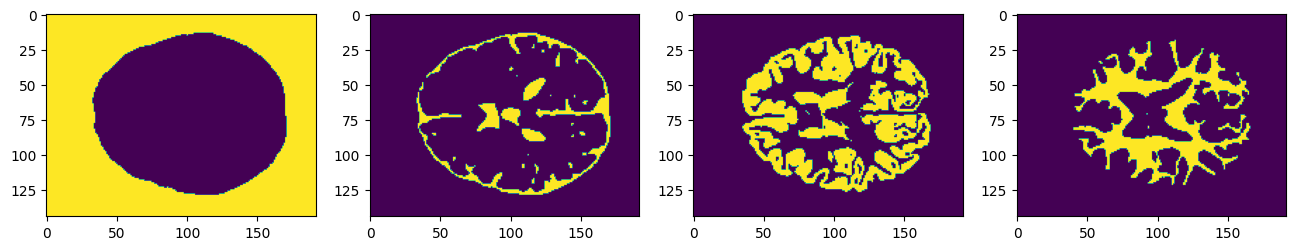

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(16,8))
for i in range(4):
    ax[i].imshow(gt[9,:,:,153,i]) # 10e patient

T1 et T2 sont 2 canaux d'une image :

In [13]:
data = np.concatenate([t1, t2], axis=-1)
data.shape, gt.shape

((10, 144, 192, 256, 2), (10, 144, 192, 256, 4))

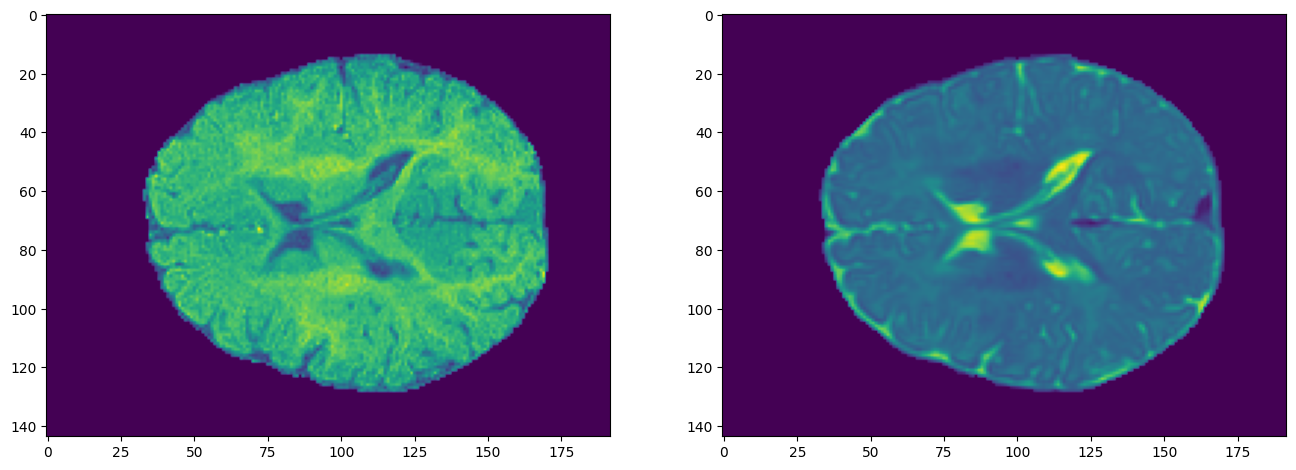

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
for i in range(2):
    ax[i].imshow(data[9,:,:,153,i]) # 10e patient

In [15]:
del(t1)
del(t2)

In [16]:
import sys
sys.getsizeof(data)/(1024*1024), sys.getsizeof(gt)/(1024*1024)

(540.0001678466797, 270.0001678466797)

#### Nomalisation
On normalise et centre nos données.

In [17]:
data = (data - np.mean(data)) / np.std(data)

#### Générateur

<description de mon générateur>

In [18]:
def pad_to_square(image, gt=False):
    h, w = image.shape[:2]
    pad_h = (256 - h) // 2
    pad_w = (256 - w) // 2

    if not gt:
        padded = np.pad(image, 
                        ((pad_h, 256 - h - pad_h), 
                         (pad_w, 256 - w - pad_w),
                         (0, 0)), 
                        mode='constant', constant_values=-0.33296487)
    else:
        channels = image.shape[-1]
        padded = np.pad(image,
                        ((pad_h, 256 - h - pad_h),
                         (pad_w, 256 - w - pad_w),
                         (0, 0)),
                        mode='constant',
                        constant_values=0)
        pad_mask = np.zeros((256, 256), dtype=bool)
        pad_mask[:pad_h, :] = True
        pad_mask[256 - (256 - h - pad_h):, :] = True
        pad_mask[:, :pad_w] = True
        pad_mask[:, 256 - (256 - w - pad_w):] = True

        padded[pad_mask, 0] = 1
    return padded

def unpad_from_square(image, axis):
    original_shapes = {
        0: (192, 256),
        1: (144, 256),
        2: (144, 192)
    }
    
    h, w = original_shapes[axis]
    
    pad_h = (256 - h) // 2
    pad_w = (256 - w) // 2
    
    unpadded = image[pad_h:pad_h + h, pad_w:pad_w + w]
    
    return unpadded

In [19]:
class SlicesGenerator(keras.utils.Sequence):
    
    def __init__(self, data, gt, batch_size=8):
        self.data = data
        self.gt = gt
        self.batch_size = batch_size
       
    def __len__(self):
        shape = self.data.shape
        return (shape[0] * shape[1] + shape[0] * shape[2] + shape[0] * shape[3]) // self.batch_size
    
    def __getitem__(self, idx):
        batch_x, batch_y = [], []
        random_axis = rnd_g.integers(3)

        for i in range(self.batch_size):
            random_patient = rnd_g.integers(self.data.shape[0])
            random_slice = rnd_g.integers(self.data.shape[random_axis + 1])
            match random_axis:
                case 0:
                    batch_x.append(pad_to_square(self.data[random_patient, random_slice, :, :, :]))
                    batch_y.append(pad_to_square(self.gt[random_patient, random_slice, :, :, :], True))
                case 1:
                    batch_x.append(pad_to_square(self.data[random_patient, :, random_slice, :, :]))
                    batch_y.append(pad_to_square(self.gt[random_patient, :, random_slice, :, :], True))
                case 2:
                    batch_x.append(pad_to_square(self.data[random_patient, :, :, random_slice, :]))
                    batch_y.append(pad_to_square(self.gt[random_patient, :, :, random_slice, :], True))

        return np.array(batch_x), np.array(batch_y).astype('float32')

Je regarde ce que donne mon générateur.

In [20]:
generator = SlicesGenerator(data, gt)

## Le réseau

Il s'agit du U-net classique.

In [21]:
inputs = keras.Input(shape=(256, 256, 2))
c1 = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=activations.relu)(inputs)
c1 = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=activations.relu)(c1)
mp1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

c2 = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=activations.relu)(mp1)
c2 = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=activations.relu)(c2)
mp2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

c3 = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation=activations.relu)(mp2)
c3 = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation=activations.relu)(c3)
mp3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)

c4 = layers.Conv2D(filters=512, kernel_size=3, padding="same", activation=activations.relu)(mp3)
c4 = layers.Conv2D(filters=512, kernel_size=3, padding="same", activation=activations.relu)(c4)
mp4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = layers.Conv2D(filters=1024, kernel_size=3, padding="same", activation=activations.relu)(mp4)
c5 = layers.Conv2D(filters=1024, kernel_size=3, padding="same", activation=activations.relu)(c5)

u6 = layers.Conv2DTranspose(filters=512, kernel_size=2, strides=2, padding="same", activation=activations.relu)(c5)
m6 = layers.Concatenate()([u6, c4])
c6 = layers.Conv2D(filters=512, kernel_size=3, padding="same", activation=activations.relu)(m6)
c6 = layers.Conv2D(filters=512, kernel_size=3, padding="same", activation=activations.relu)(c6)

u7 = layers.Conv2DTranspose(filters=256, kernel_size=2, strides=2, padding="same", activation=activations.relu)(c6)
m7 = layers.Concatenate()([u7, c3])
c7 = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation=activations.relu)(m7)
c7 = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation=activations.relu)(c7)

u8 = layers.Conv2DTranspose(filters=128, kernel_size=2, strides=2, padding="same", activation=activations.relu)(c7)
m8 = layers.Concatenate()([u8, c2])
c8 = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=activations.relu)(m8)
c8 = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=activations.relu)(c8)

u9 = layers.Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding="same", activation=activations.relu)(c8)
m9 = layers.Concatenate()([u9, c1])
c9 = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=activations.relu)(m9)
c9 = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=activations.relu)(c9)

outputs = layers.Conv2D(filters=4, kernel_size=1, padding="same", activation=activations.softmax)(c9)

model = keras.Model(inputs, outputs)

I0000 00:00:1762962539.511441   18055 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762962539.512093   18055 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [22]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.CategoricalCrossentropy())

In [23]:
BATCH_SIZE = 16

train_gen = SlicesGenerator(data[:-2], gt[:-2], batch_size = BATCH_SIZE) # 8 patients pour l'entrainement
val_gen = SlicesGenerator(data[-2:-1], gt[-2:-1], batch_size = BATCH_SIZE) # 1 patient pour la validation

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,216 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,364 (118.38 MB)

 Trainable params: 31,031,364 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
nb_iter = 100
model.fit(train_gen, validation_data=val_gen, epochs=nb_iter)

## Analyse du résultat

In [25]:
#model.save_weights('/kaggle/input/weights/u-net_best.weights.h5')
model.load_weights('/kaggle/input/weights/u-net_best.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
def plot_res(indice, axis):
    if axis == 0:
        img = pad_to_square(data[0, indice, :, :, :])
        g = gt[0, indice, :, :, :]
    elif axis == 1:
        img = pad_to_square(data[0, :, indice, :, :])
        g = gt[0, :, indice, :, :]
    else:
        img = pad_to_square(data[0, :, :, indice, :])
        g = gt[0, :, :, indice, :]

    img_batch = np.expand_dims(img, axis=0)
    
    res = unpad_from_square(model.predict(img_batch)[0], axis)
    
    fig, ax = plt.subplots(1, 3, figsize=(16,10))

    ax[0].imshow(10*res[:,:,0] + 50*res[:,:,1] + 150*res[:,:,2] + 250*res[:,:,3])
    ax[0].set_title("Comb. linéaire")

    image_seuil = 10*res[:,:,0] + 50*res[:,:,1] + 150*res[:,:,2] + 250*res[:,:,3]
    if (image_seuil == 0).sum() > 0:
        print("Nombre de pixels non déterminés par le seuil :", (image_seuil == 0).sum())
    ax[1].imshow(image_seuil)
    ax[1].set_title("Seuils")

    ax[2].imshow(10*g[:,:,0] + 50*g[:,:,1] + 150*g[:,:,2] + 250*g[:,:,3])
    ax[2].set_title("Vérité terrain")


I0000 00:00:1762962555.830707   18114 service.cc:148] XLA service 0x7e2038010da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762962555.830767   18114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762962555.830773   18114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762962555.955366   18114 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1762962561.784413   18114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


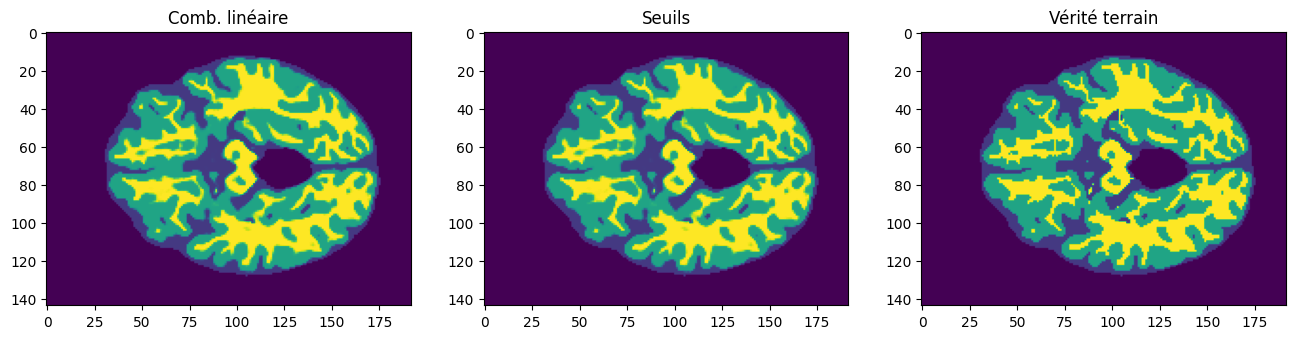

In [27]:
plot_res(119, 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


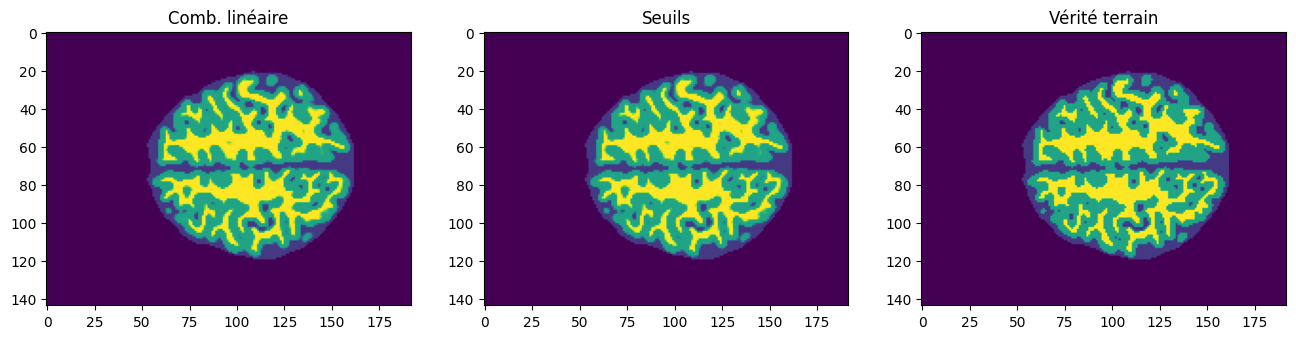

In [28]:
plot_res(172,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


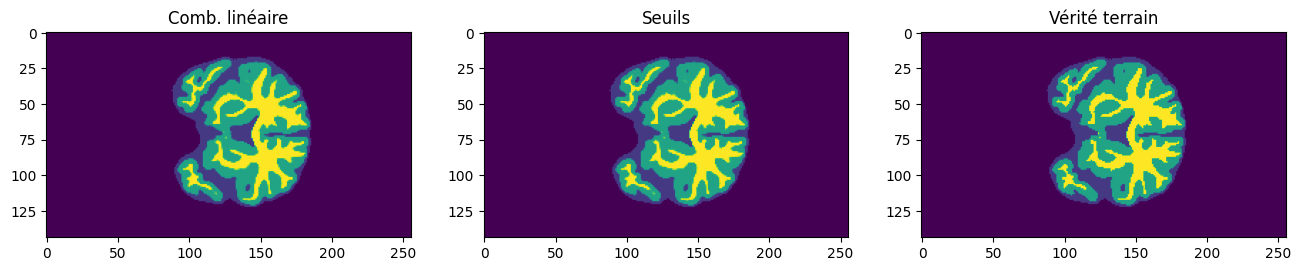

In [29]:
plot_res(77,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


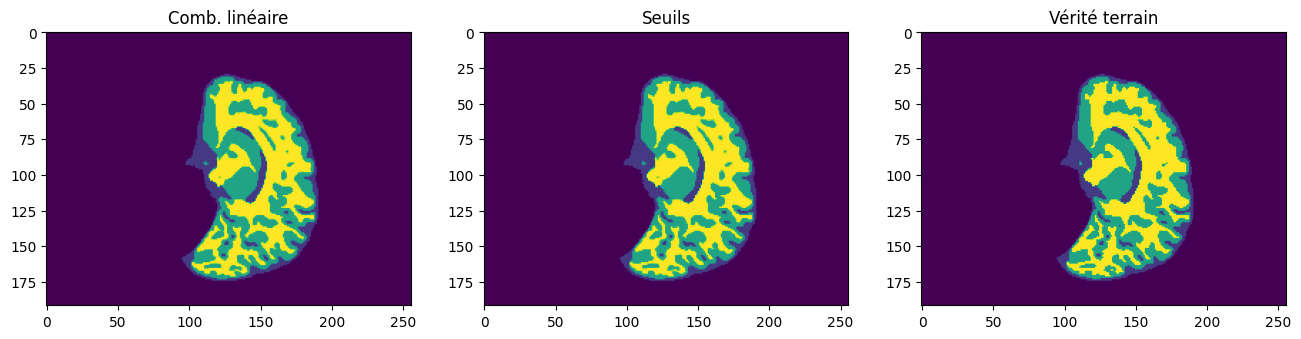

In [30]:
plot_res(82, 0)

## Post-traitement

Astuces pour améliorer le résultat.

Calcul de l'erreur intersection sur union :

In [31]:
def iou(brain, gt):
    gt_labels = np.argmax(gt, axis=-1)
    brain_labels = np.argmax(brain, axis=-1)
    
    iou_per_class = []
    
    for class_id in range(4):
        gt_mask = (gt_labels == class_id)
        brain_mask = (brain_labels == class_id)
        
        intersection = np.logical_and(gt_mask, brain_mask).sum()
        union = np.logical_or(gt_mask, brain_mask).sum()
        
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union
        
        iou_per_class.append(iou)
    
    mean_iou = np.mean(iou_per_class)
    
    return np.array(iou_per_class), mean_iou

In [32]:
img = pad_to_square(data[0, :, :, 119, :])
img_batch = np.expand_dims(img, axis=0)
brain = unpad_from_square(model.predict(img_batch)[0], 2)

print(iou(brain, gt[0, :, :, 119, :]))

img = pad_to_square(data[0, :, :, 172, :])
img_batch = np.expand_dims(img, axis=0)
brain = unpad_from_square(model.predict(img_batch)[0], 2)

print(iou(brain, gt[0, :, :, 172, :]))

img = pad_to_square(data[0, :, 77, :, :])
img_batch = np.expand_dims(img, axis=0)
brain = unpad_from_square(model.predict(img_batch)[0], 1)

print(iou(brain, gt[0, :, 77, :, :]))

img = pad_to_square(data[0, 82, :, :, :])
img_batch = np.expand_dims(img, axis=0)
brain = unpad_from_square(model.predict(img_batch)[0], 0)

print(iou(brain, gt[0, 82, :, :, :]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(array([1.        , 0.94708382, 0.93048897, 0.91555098]), 0.948280942157794)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
(array([1.        , 0.9471891 , 0.94406257, 0.94316375]), 0.9586038557902211)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
(array([1.        , 0.97627907, 0.96334311, 0.95039293]), 0.9725037763950721)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(array([1.        , 0.97721963, 0.96447432, 0.9725481 ]), 0.9785605103856443)


## Création du ma segmentation sur les données de test

In [33]:
t1 = [nib.load(f"{DATA_TEST}/subject-{x}-T1.img").get_fdata() for x in range(11,24)]
t2 = [nib.load(f"{DATA_TEST}/subject-{x}-T2.img").get_fdata() for x in range(11,24)]

In [34]:
t1[12] = t1[12][8:-8, :, :, :]
t2[12] = t2[12][8:-8, :, :, :]

In [35]:
data = np.stack([np.concatenate([t1[i], t2[i]], axis=-1) for i in range(13)], axis=0).astype('float32')

In [36]:
data.shape

(13, 144, 192, 256, 2)

In [37]:
# normalisation
data = (data - np.mean(data)) / np.std(data)

Je génère ma segmentation sur le cerveau en 3D.

In [38]:
def predict_volume(subject_idx=0, batch_size=16):
    subj = data[subject_idx - 11]
    H, W, D, C = subj.shape
    out_channels = model.output_shape[-1]

    preds_vol = np.zeros((H, W, D, out_channels), dtype='float32')

    for start in range(0, D, batch_size):
        end = min(start + batch_size, D)
        batch_imgs = []
        slice_indices = list(range(start, end))

        for z in slice_indices:
            img = pad_to_square(subj[:, :, z, :])
            batch_imgs.append(img)

        batch_arr = np.stack(batch_imgs, axis=0)
        pred_batch = model.predict(batch_arr)

        for i, z in enumerate(slice_indices):
            pred_slice = pred_batch[i]
            unp = unpad_from_square(pred_slice, 2)
            preds_vol[:, :, z, :] = unp

    return preds_vol

In [39]:
def show_slice(subject_idx, z, volume):
    subj = data[subject_idx - 11]
    H, W, D, C = subj.shape
    assert 0 <= z < D, f"z doit être entre 0 et {D-1}"

    t1 = subj[:, :, z, 0]
    t2 = subj[:, :, z, 1] if C > 1 else subj[:, :, z, 0]

    pred_mask = np.argmax(volume, axis=-1)
    pred_slice = pred_mask[:, :, z]

    label_values = np.array([0, 10, 150, 250], dtype=np.uint8)
    pred_values = label_values[pred_slice]

    fig, ax = plt.subplots(1, 3, figsize=(16, 6))
    ax[0].imshow(t1, cmap='gray')
    ax[0].set_title(f"T1 — slice {z}")
    ax[1].imshow(t2, cmap='gray')
    ax[1].set_title(f"T2 — slice {z}")
    ax[2].imshow(pred_values)
    ax[2].set_title(f"Prediction (valeurs 0,10,150,250) — slice {z}")
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

Prediction sujet 11...
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


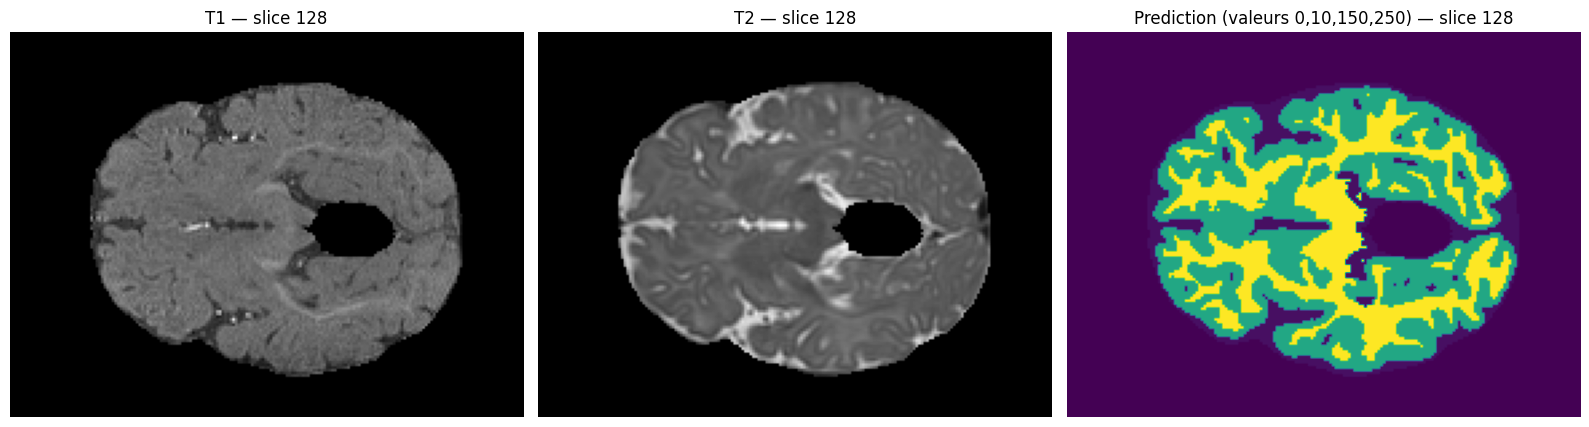

Prediction sujet 12...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


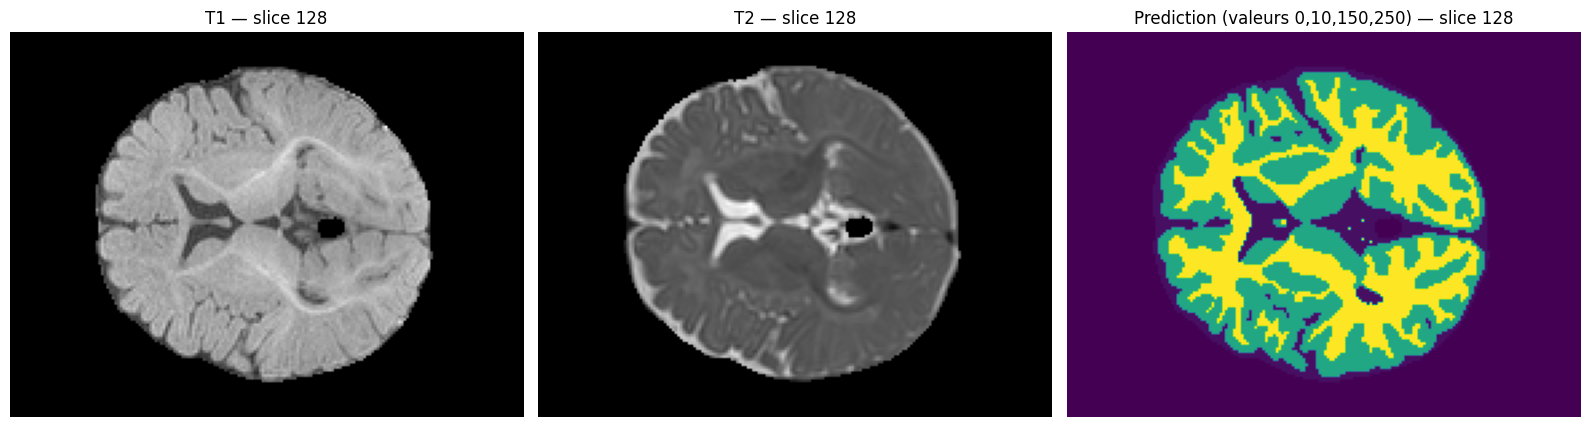

Prediction sujet 13...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


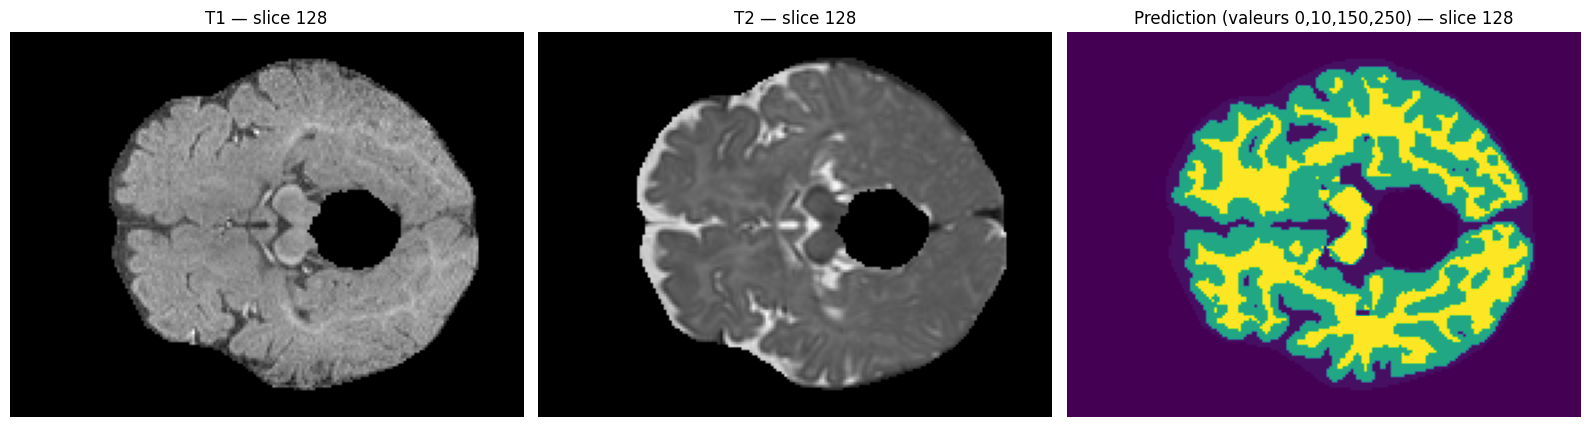

Prediction sujet 14...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


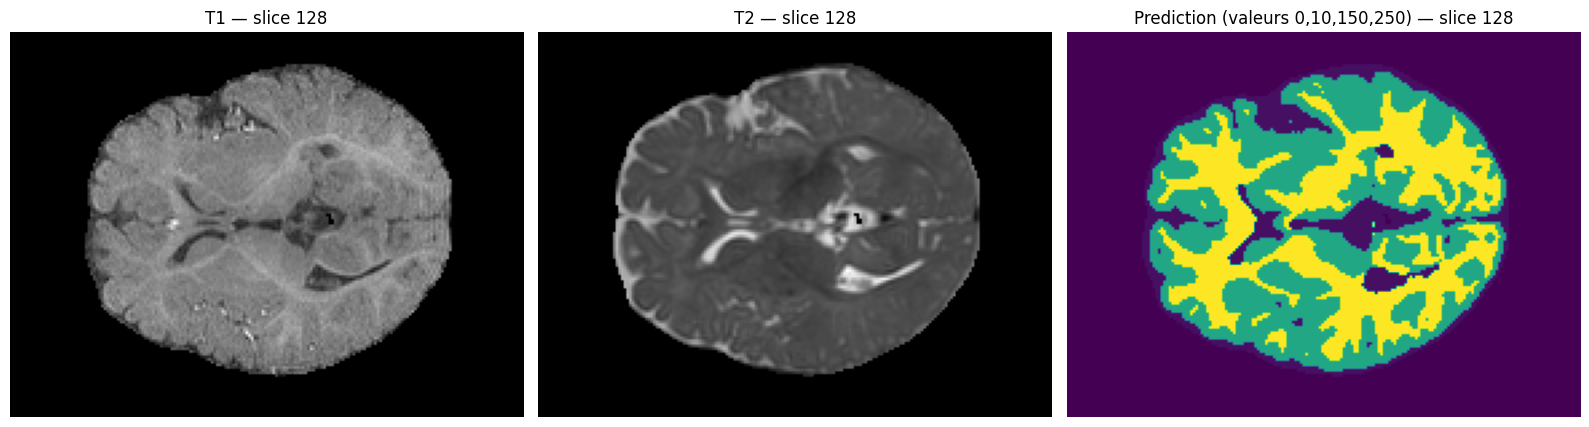

Prediction sujet 15...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


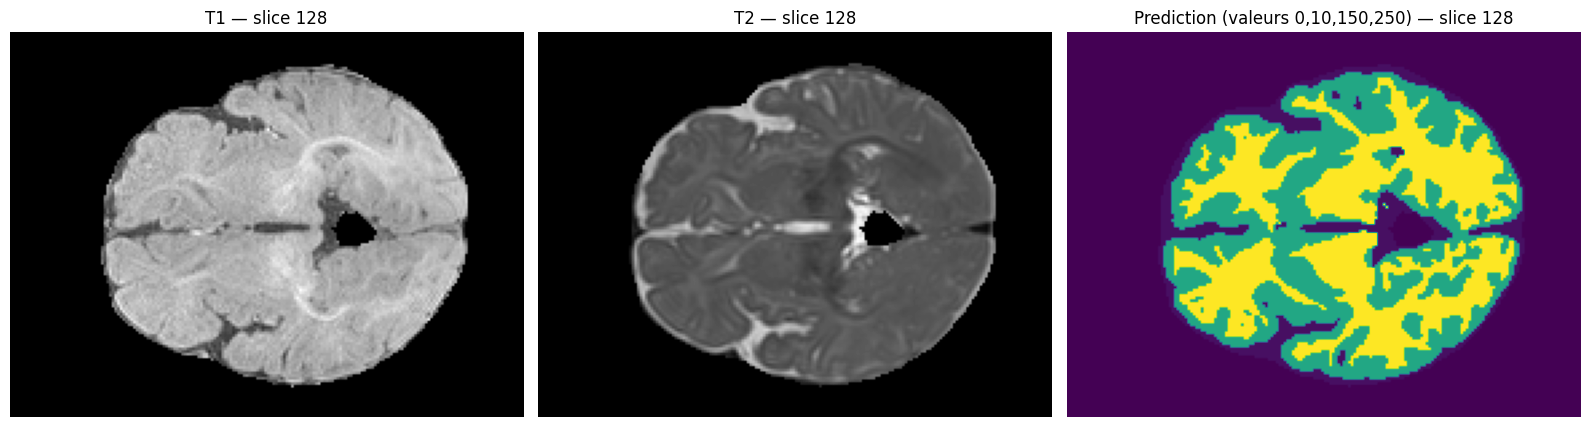

Prediction sujet 16...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


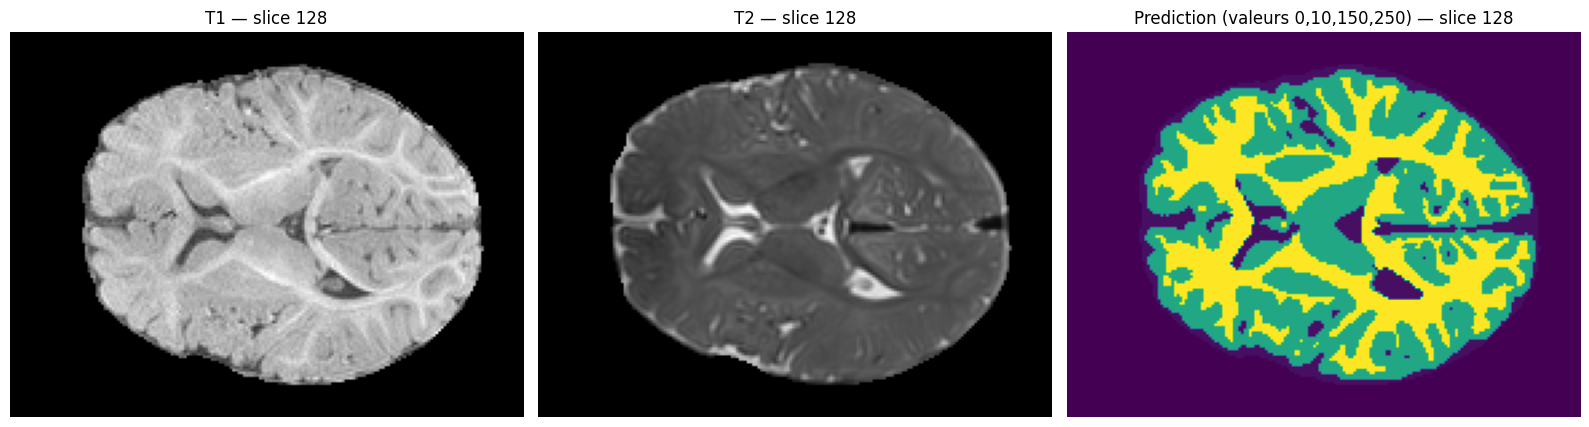

Prediction sujet 17...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


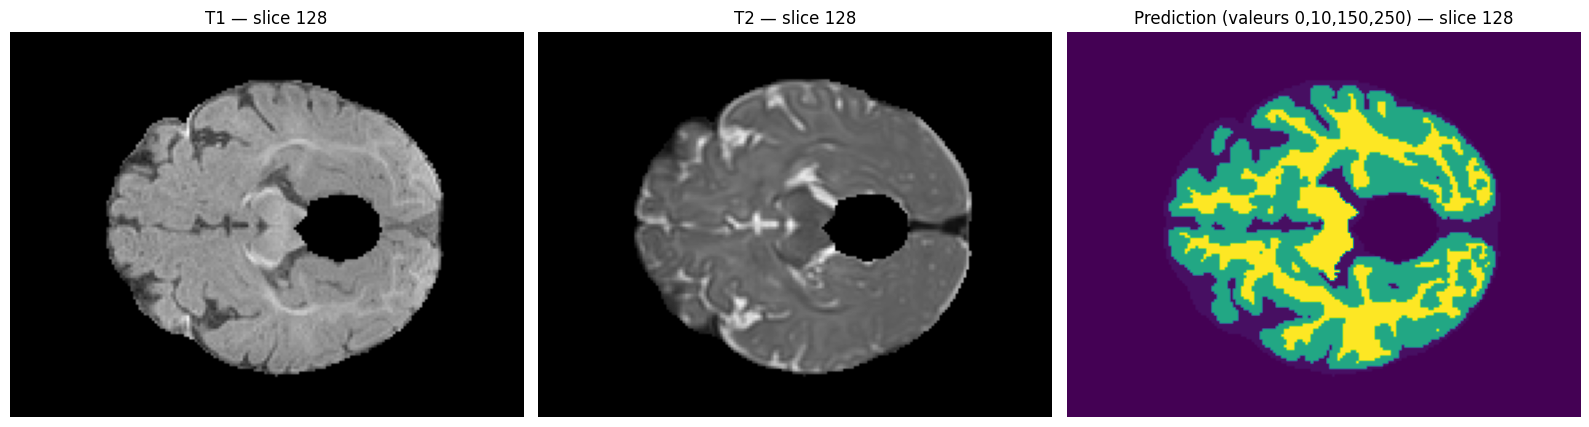

Prediction sujet 18...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


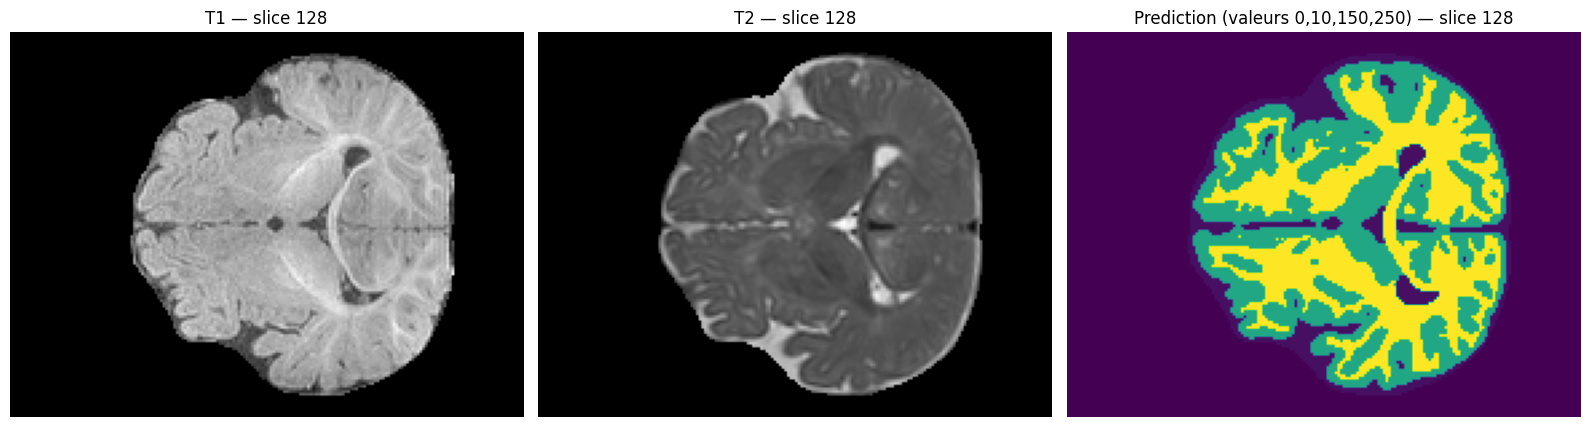

Prediction sujet 19...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


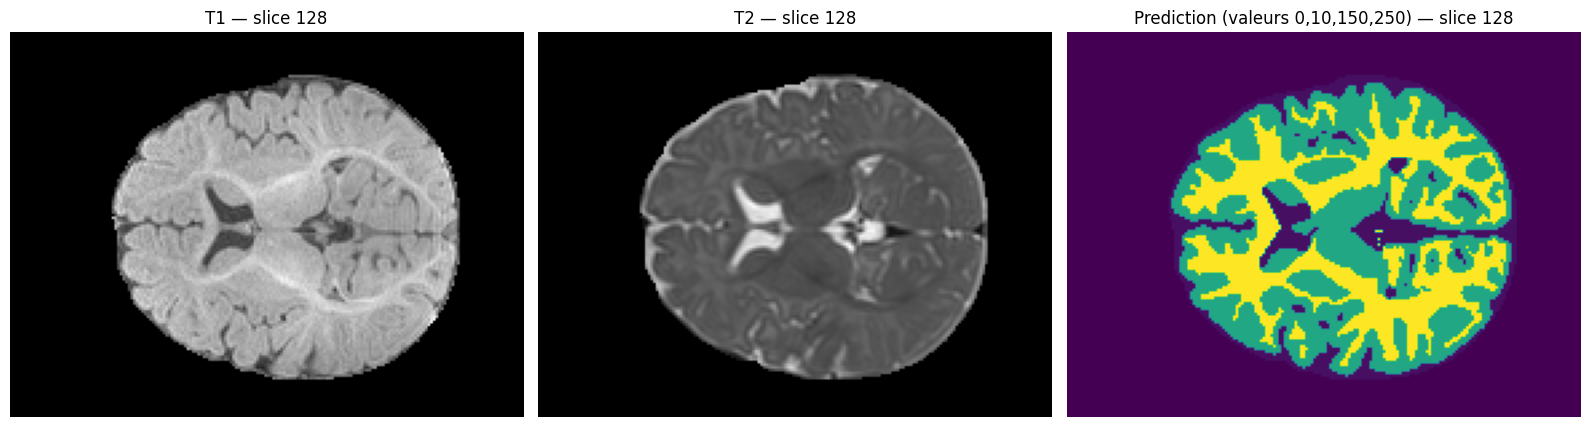

Prediction sujet 20...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


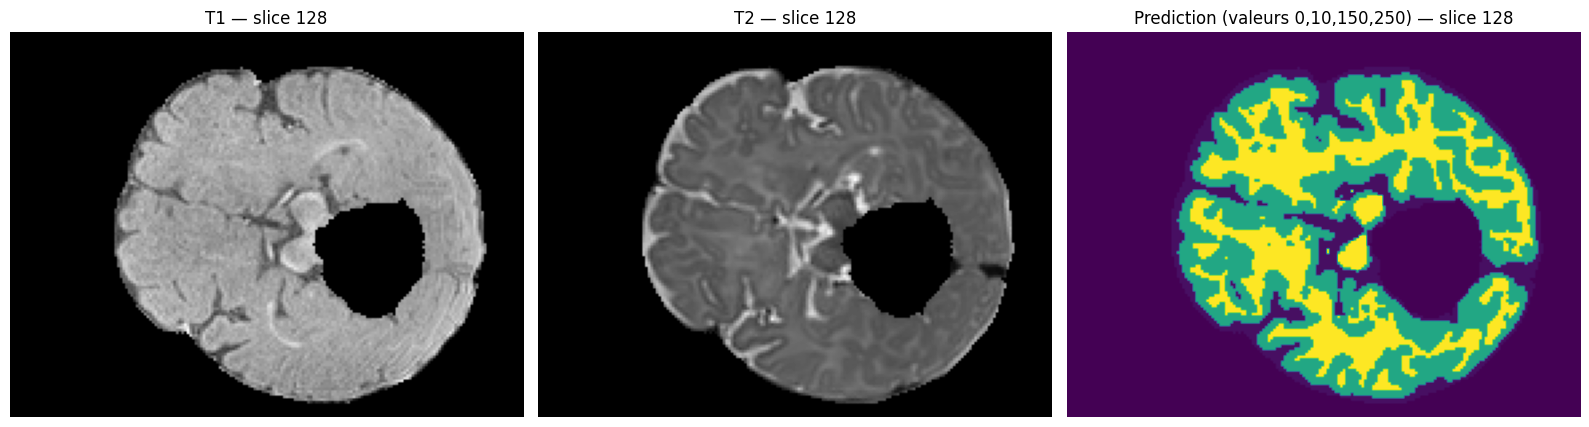

Prediction sujet 21...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


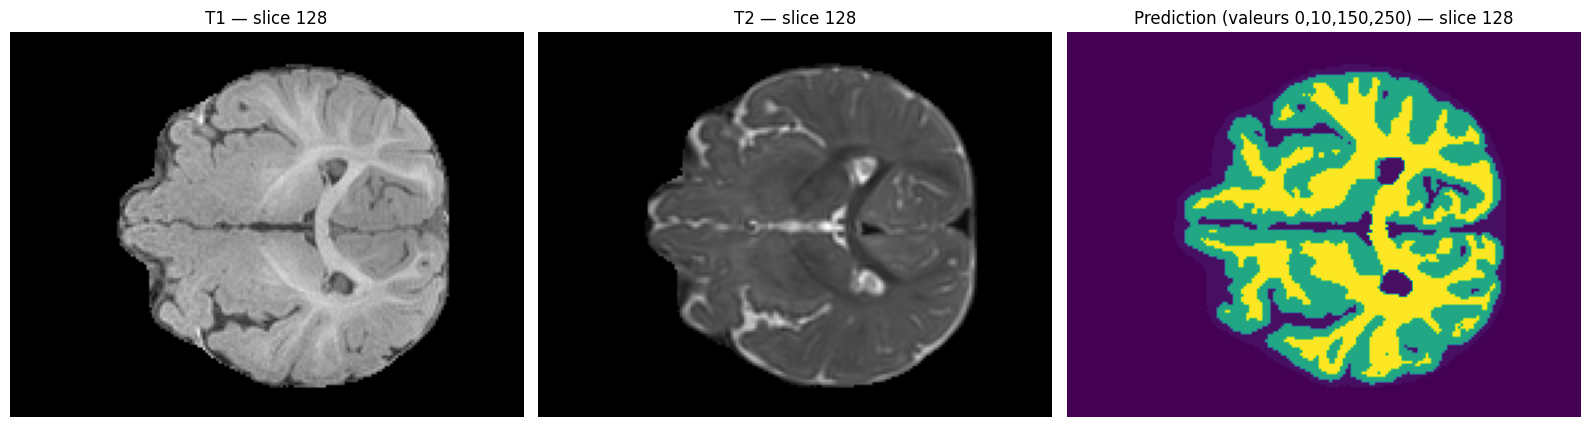

Prediction sujet 22...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


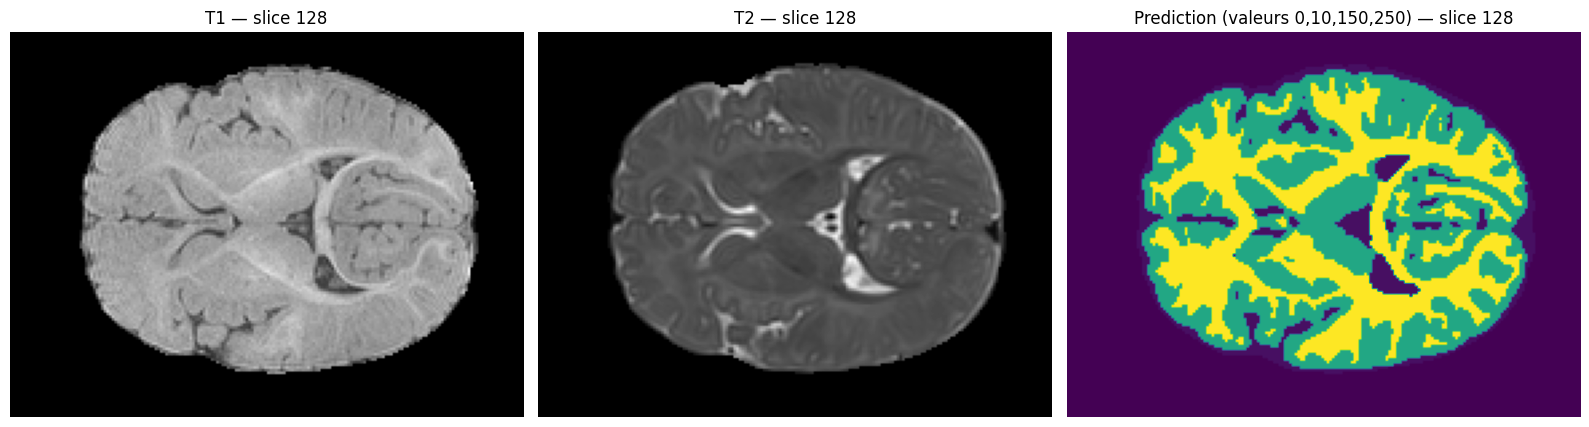

Prediction sujet 23...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


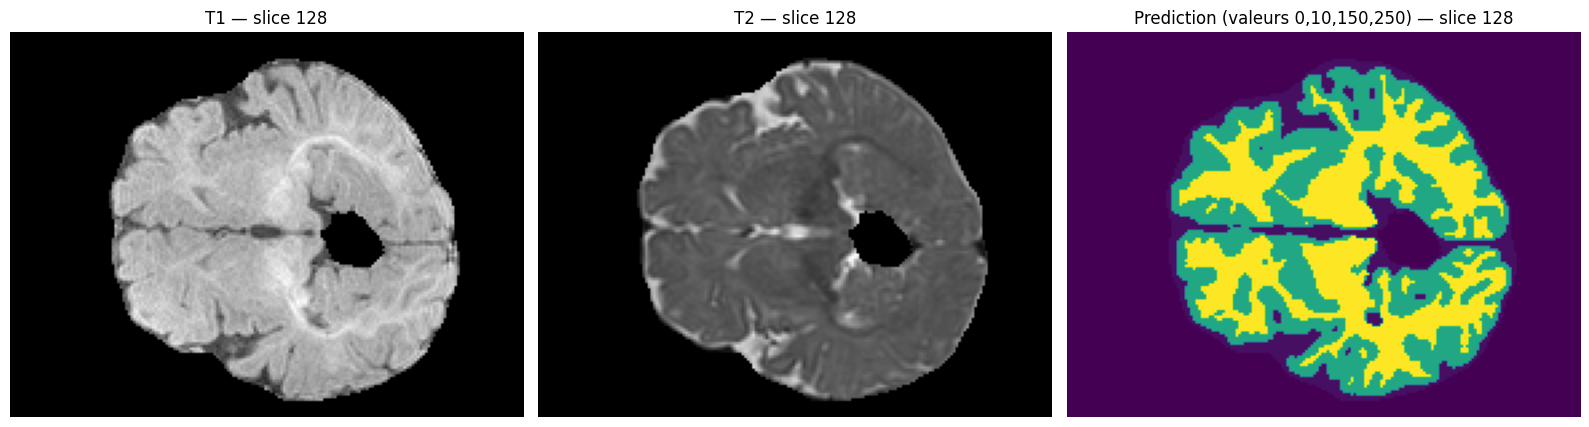

In [40]:
def restore_padding(volume):
    H, W, D, C = volume.shape
    restored = np.zeros((H + 2*8, W, D, C), dtype=volume.dtype)
    restored[8:-8, :, :, :] = volume
    return restored


all_preds = {}

for sub in range(11, 24):
    print(f"Prediction sujet {sub}...")
    preds = predict_volume(subject_idx=sub, batch_size=32)
    show_slice(sub, 128, preds)

    if sub == 23:
        preds = restore_padding(preds)

    mask = np.argmax(preds, axis=-1)
    bool_preds = np.zeros_like(preds, dtype=bool)
    for c in range(preds.shape[-1]):
        bool_preds[..., c] = (mask == c)

    all_preds[f"subject-{sub}"] = bool_preds

np.savez_compressed("brain_OR.npz", **all_preds)

#### Création du fichier à soumettre

In [41]:
brain = np.load("brain_OR.npz")

In [42]:
brain.files

['subject-11',
 'subject-12',
 'subject-13',
 'subject-14',
 'subject-15',
 'subject-16',
 'subject-17',
 'subject-18',
 'subject-19',
 'subject-20',
 'subject-21',
 'subject-22',
 'subject-23']

In [43]:
for b in brain.files:
    print(brain[b].shape, brain[b].dtype)

(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(144, 192, 256, 4) bool
(160, 192, 256, 4) bool


In [44]:
def rle_encoding(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])  # Ajout de 0 en début et fin pour délimiter
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1  # Détection des changements
    runs[1::2] -= runs[::2]  # Calcul des longueurs
    return ' '.join(str(x) for x in runs)

In [45]:
layers = [[102,  77,  49,  82],
          [ 54, 157,  35, 156],
          [149, 110, 181,  86]]

In [46]:
res = []
i = 0
for sub in range(11, 23):
    for axis in range(3):
        for layer in layers[axis]:
            for material in range(4):
                img = brain[f"subject-{sub}"].take(layer, axis=axis)
                rle = rle_encoding(img[...,material])
                res.append(f"i{i}, {img.shape[0]}, {img.shape[1]}, {rle}")
                i += 1
len(res)            

576

In [47]:
with open('brain_TG.csv', 'w') as fichier:
    fichier.write("Id, Height, Width, RLE\n")
    for l in res:
        fichier.write(l + '\n')